In [11]:
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Load the dataset
data, meta = arff.loadarff("../data/our/hpc_job_scheduling.arff")
df = pd.DataFrame(data)

# Display basic information about the dataset
print("Basic Information:")
print(df.info())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4331 entries, 0 to 4330
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Protocol     4331 non-null   object 
 1   Compounds    4331 non-null   float64
 2   InputFields  4331 non-null   float64
 3   Iterations   4331 non-null   float64
 4   NumPending   4331 non-null   float64
 5   Hour         4331 non-null   float64
 6   Day          4331 non-null   object 
 7   Class        4331 non-null   object 
dtypes: float64(5), object(3)
memory usage: 270.8+ KB
None


In [12]:
# Created a new dataset with timestamps instead of day + hour. Instead a timestamp day * 24 + hour is used. 

day_to_num = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
df['Day'] = df['Day'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
df['Day'] = df['Day'].str.strip().str.capitalize().map(day_to_num)

# Combine 'Day' and 'Hour' into a single timestamp
df['Timestamp'] = df['Day'] * 24 + df['Hour']

# Normalize the 'Timestamp' column to be in the range 0 to 1
df['Normalized_Timestamp'] = (df['Timestamp'] - df['Timestamp'].min()) / (df['Timestamp'].max() - df['Timestamp'].min())

# Print the resulting DataFrame
df.to_csv('../data_processed/hpc_analysis_with_timestamps.csv', index=False)  # Set the file name to your desired path

In [13]:
df = pd.read_csv('../data_processed/hpc_job_scheduling_with_timestamps.csv')

bin_columns = []
cat_columns = ['Protocol', 'Day', 'Class']
ordinal_columns = ['Hour']
continuous_columns = ['Compounds', 'InputFields', 'Iterations', 'NumPending', 'Timestamp', 'Normalized_Timestamp']

# Step 3: Convert columns to the required types
df['Protocol'] = df['Protocol'].astype('category')
df['Compounds'] = df['Compounds'].astype(float)
df['InputFields'] = df['InputFields'].astype(float)
df['Iterations'] = df['Iterations'].astype(float)
df['NumPending'] = df['NumPending'].astype(float)
df['Hour'] = df['Hour'].astype(float)
df['Day'] = df['Day'].astype('category')
df['Class'] = df['Class'].astype('category')
df['Timestamp'] = df['Timestamp'].astype(float)
df['Normalized_Timestamp'] = df['Normalized_Timestamp'].astype(float)

# Step 4: Define the column types metadata
column_types = {
    "bin": bin_columns,
    "cat": cat_columns,
    "ord": ordinal_columns,
    "cont": continuous_columns,
    "target": 'Class'  # Define your target column if applicable
}

# Step 5: Save the column types metadata to a pkl file
with open('../data_processed/hpc_job_scheduling_with_timestamps.pkl', 'wb') as f:
    pickle.dump(column_types, f)
f.close()
print("Column types metadata has been successfully saved as 'dataset_column_types.pkl'.")

Column types metadata has been successfully saved as 'dataset_column_types.pkl'.


Description
These data consist of information on 4331 jobs in a high performance computing environment. Seven attributes were recorded for each job along with a discrete class describing the execution time.

The predictors are: Protocol (the type of computation), Compounds (the number of data points for each jobs), InputFields (the number of characteristic being estimated), Iterations (maximum number of iterations for the computations), NumPending (the number of other jobs pending at the time of launch), Hour (decimal hour of day for launch time) and Day (of launch time).

The classes are: VF (very fast), F (fast), M (moderate) and L (long).

In [14]:
meta

Dataset: 'x'
	Protocol's type is nominal, range is ('A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O')
	Compounds's type is numeric
	InputFields's type is numeric
	Iterations's type is numeric
	NumPending's type is numeric
	Hour's type is numeric
	Day's type is nominal, range is ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
	Class's type is nominal, range is ('VF', 'F', 'M', 'L')

# Key points
- 8 features:
  - 5 numeric: [Compounds,InputFields,Iterations,NumPending,Hour]
  - 2 nominal: [Protocol {'A','C','D','E','F','G','H','I','J','K','L','M','N','O'}, Day {'Mon','Tue','Wed','Thu','Fri','Sat','Sun'}]
  - 1 ordinal: [Class] 
- zero missing values.
- class is a categorical attribute meaning how fast the job was done:  {'VF' (Very Fast), 'F' (Fast), 'M' (Medium), 'L' (Long)}

Assign proper types to int values.

In [15]:
df = df.astype({
    "Compounds": int,
    "InputFields": int,
    "Iterations": int,
    "NumPending": int
})

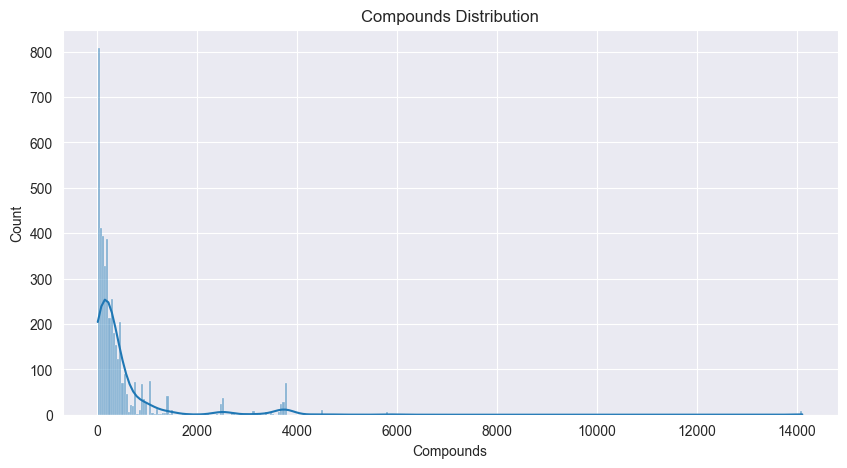

In [16]:
# Compounds distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Compounds'], kde=True)
plt.title('Compounds Distribution')
plt.show()



As we can see, the compounds are not well-distributed. Let's try to remove last (highest) 22 compounds entries:

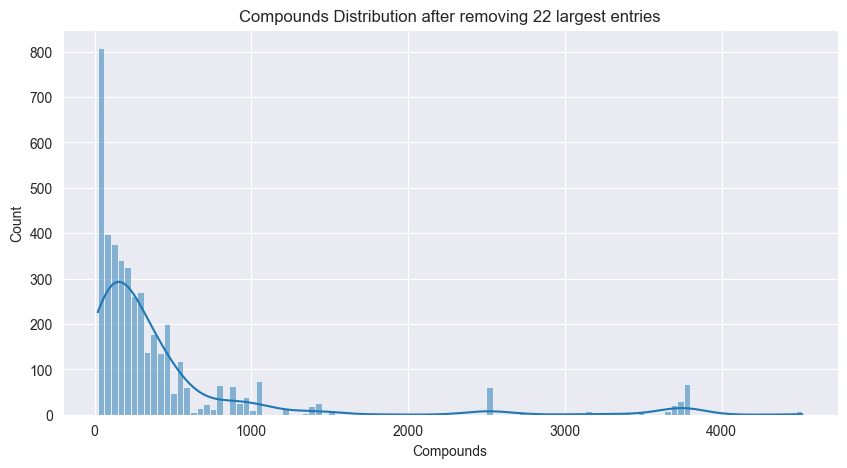

In [17]:
df_sorted = df.sort_values(by='Compounds', ascending=False).iloc[22:]
plt.figure(figsize=(10, 5))
sns.histplot(df_sorted['Compounds'], kde=True)
plt.title('Compounds Distribution after removing 22 largest entries')
plt.show()

If we remove the last 22 entries (out of 4331), it is going to look better. We can see a more smooth initial decrease, but the amount of entries with high compounds is still high. Therefore, we cannot simply drop any of the compounds.  

Let's see how it looks with input fields:

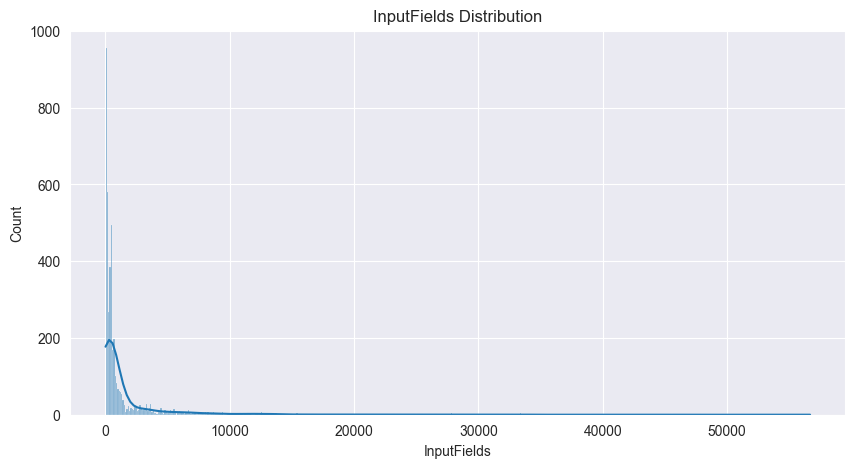

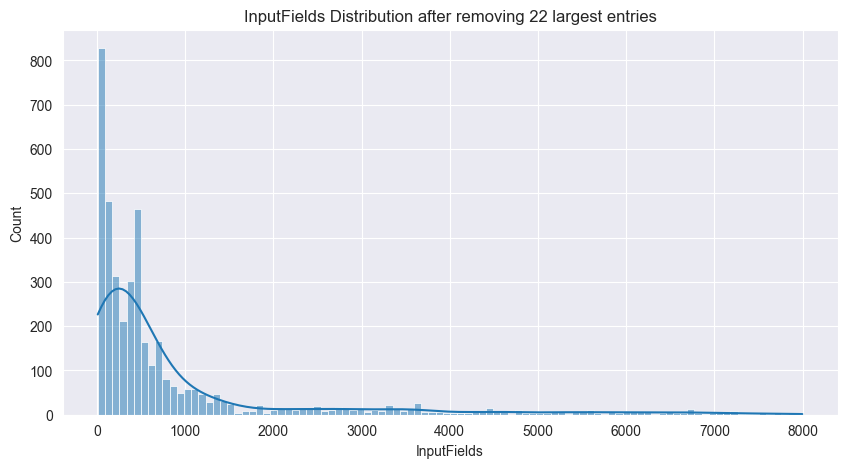

In [18]:
# InputFields distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['InputFields'], kde=True)
plt.title('InputFields Distribution')
plt.show()

df_sorted = df.sort_values(by='InputFields', ascending=False).iloc[202:]
plt.figure(figsize=(10, 5))
sns.histplot(df_sorted['InputFields'], kde=True)
plt.title('InputFields Distribution after removing 22 largest entries')
plt.show()

The same situation is here: there is a sufficient amount of input fields distributed across the whole x-axis.

Remaining distributions:

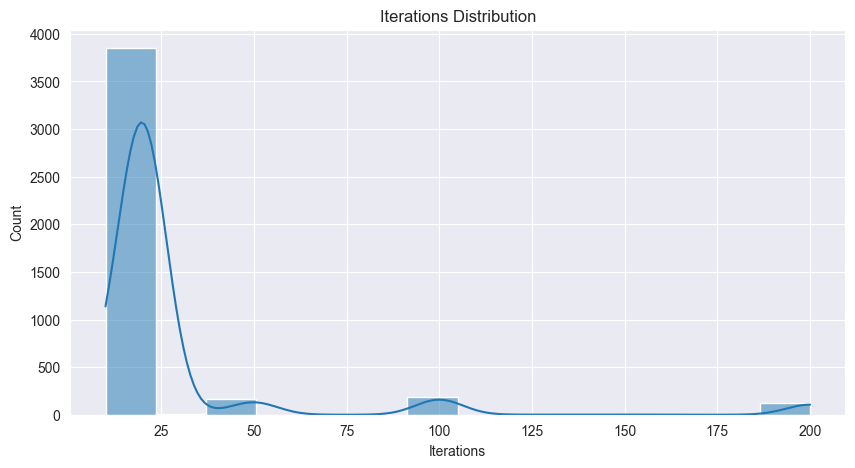

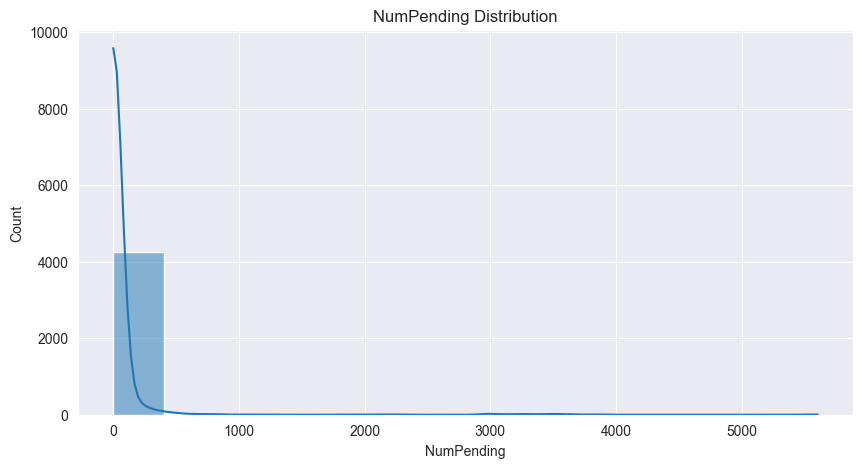

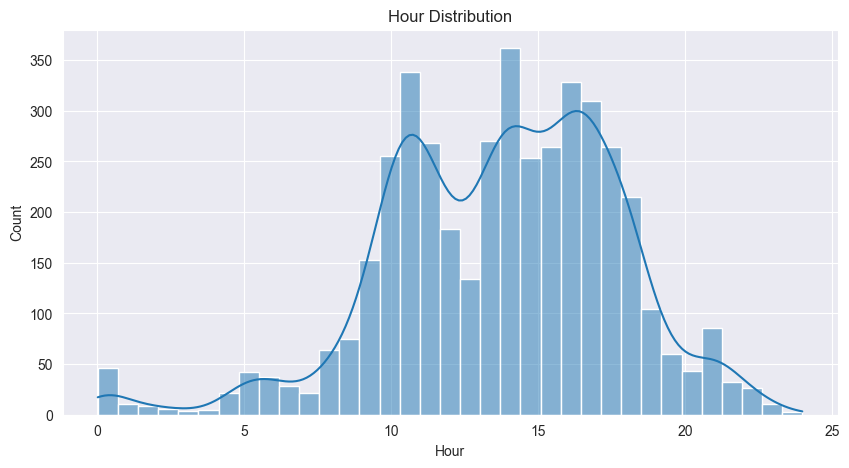

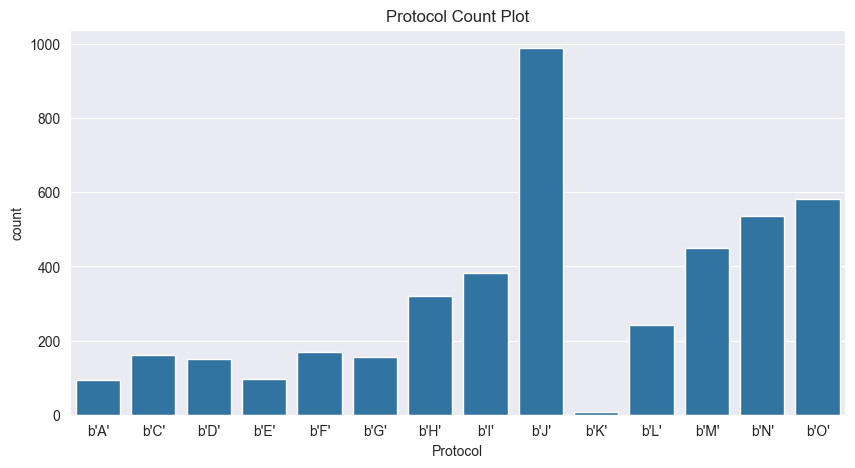

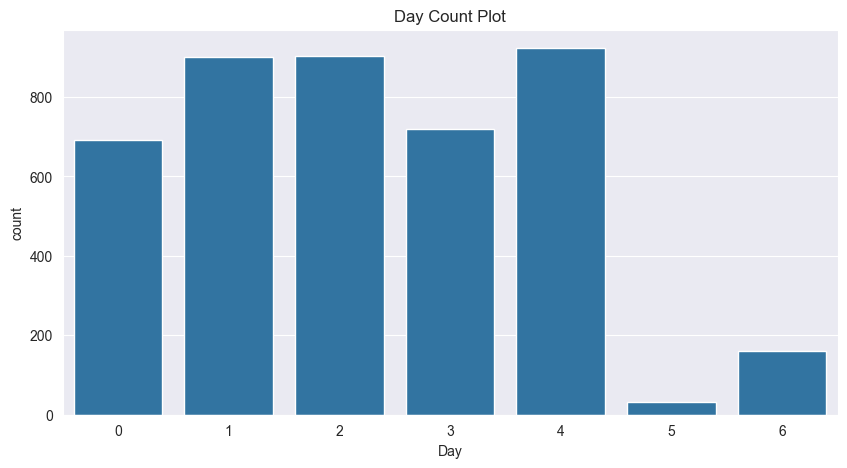

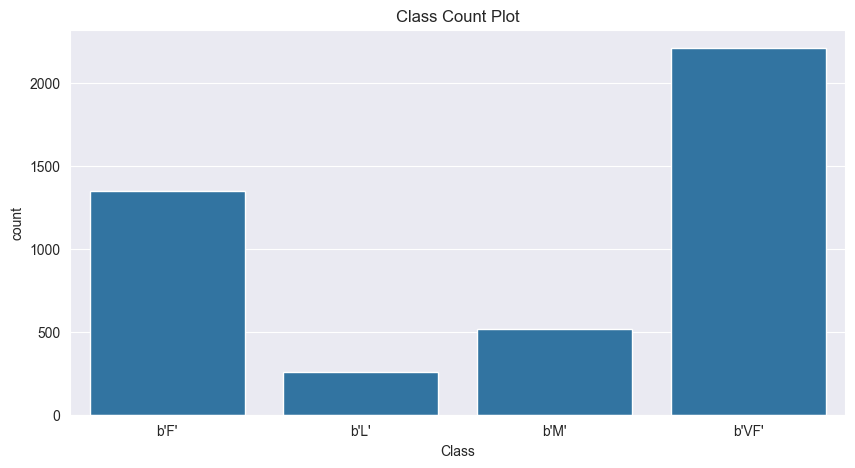

In [19]:
# Iterations distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Iterations'], kde=True)
plt.title('Iterations Distribution')
plt.show()

# NumPending distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['NumPending'], kde=True)
plt.title('NumPending Distribution')
plt.show()

# Hour distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Hour'], kde=True)
plt.title('Hour Distribution')
plt.show()

# Protocol countplot
plt.figure(figsize=(10, 5))
sns.countplot(x='Protocol', data=df)
plt.title('Protocol Count Plot')
plt.show()

# Day countplot
plt.figure(figsize=(10, 5))
sns.countplot(x='Day', data=df)
plt.title('Day Count Plot')
plt.show()

# Class countplot
plt.figure(figsize=(10, 5))
sns.countplot(x='Class', data=df)
plt.title('Class Count Plot')
plt.show()


Biggest / Lowest / Mean / Median values for numeric columns

In [20]:
numeric_columns = ["Compounds", "InputFields", "Iterations", "NumPending", "Hour"]
for column in numeric_columns:
    print(f"Column: {column}")
    print(f"Biggest: {df[column].max()}")
    print(f"Lowest: {df[column].min()}")
    print(f"Mean: {df[column].mean()}")
    print(f"Median: {df[column].median()}\n")

Column: Compounds
Biggest: 14103
Lowest: 20
Mean: 497.7420918956361
Median: 226.0

Column: InputFields
Biggest: 56671
Lowest: 10
Mean: 1537.0554144539367
Median: 426.0

Column: Iterations
Biggest: 200
Lowest: 10
Mean: 29.243592703763564
Median: 20.0

Column: NumPending
Biggest: 5605
Lowest: 0
Mean: 53.389286538905566
Median: 0.0

Column: Hour
Biggest: 23.9833333333333
Lowest: 0.0166666666666667
Mean: 13.733760486415763
Median: 14.0166666666667

